# CS 363M Project

## Names: Gabby Galicinao, Andrea Toba, Angela Cheng, Ruchi Shah

## The Problem
<br>
Movies are one of the most popular sources of entertainment and affect a country's society, culture, and national happiness/wellbeing. We will analyze IMDb data to gain a better understanding of the factors that make movies well received by their audiences. These results can be used by movie producers and film companies to better understand the factors needed to create a great movie, as well as by the audiences to better predict if certain movies are worth watching.
<br><br>
In this project, we will attempt to predict a movie's IMDb score (a continous value from 0-worst to 10-best), using the Movie Industry dataset (https://www.kaggle.com/datasets/danielgrijalvas/movies). In the initial dataset, there are 7,668 records and 15 attributes (some categorical, some continuous).

<br>**Attribute Information:** 
- name: name of the film
- rating: G, PG, PG-13, R, etc.
- genre: comedy, action, etc.
- year: release year
- released: date of release (including the month, day, and year) and country of origin
- votes: count of IMDb user votes
- director: name of director of the film
- writer: name of writer of the film
- star: name of main actor/actress of the film
- country: the film's country of origin
- budget: amount of money used to create the film
- gross: amount of money made from the film
- company: name of production company
- runtime: length of film in minutes
- score: IMDb user rating (our class label)

In [1]:
# headers
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import rand
from numpy import square, sqrt
from pandas import DataFrame
import sklearn

## Data Prep

First, we will clean and prepare our dataset by handling missing and/or undefined values in our data, as detailed below.

There are several ambiguous categories in this dataset's rating column. Given that our dataset has many records, we chose to treat these values as NaNs (we will later remove their corresponding records from our dataset). As a safeguard, we also handled symbols such as "?".

In [2]:
missing_values = ["Not Rated", "Unrated", "Approved", "?", "na", "--"]

In [3]:
data = pd.read_csv('movies.csv', header='infer', na_values=missing_values, skipinitialspace=True)
data.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [4]:
print("Total missing values:", data.isnull().sum().sum())
print("\nMissing values by attribute:\n", data.isna().sum())
print("\n** Total missing budget values:", data['budget'].isnull().sum().sum(), " **")

Total missing values: 2809

Missing values by attribute:
 name           0
rating       413
genre          0
year           0
released       2
score          3
votes          3
director       0
writer         3
star           1
country        3
budget      2171
gross        189
company       17
runtime        4
dtype: int64

** Total missing budget values: 2171  **


The majority of our missing values come from the budget attribute, with 28% of our records missing a budget value. We decided that it was not reasonable to impute those missing values, since we do not have enough data to calculate accurate budget estimates. Additionally, we plan to create a new feature using the budget feature, so using imputed (fake) data would produce inaccurate results.
<br><br>
Since we still have a sufficient number of records without any of the records that are missing value(s), we decided that we can afford to drop all records with NaNs. As a precaution, we also make sure to drop any duplicate records.

In [5]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
print("Total number of records after dropping:", data.shape[0])

Total number of records after dropping: 5359


Next, we will drop the name column, since movie titles are (mostly) unique and are difficult to use for our score predictions.

In [6]:
data = data.drop(columns=['name'])

We then separate our labels (score) from our features (data). For now, we keep the score column in data, since during our feature engineering section we will drop a few records that would cause errors in one of our feature transformations.

In [7]:
labels = data['score']
data.head()

,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [8]:
labels.head()

0    8.4
1    5.8
2    8.7
3    7.7
4    7.3
Name: score, dtype: float64

## Data Exploration 

Next, we will explore the IMDb dataset in order to gain a better understanding of the data and detect any trends, outliers, noise, etc.

We start off by exploring the distribution of our scores.

<AxesSubplot: ylabel='Density'>

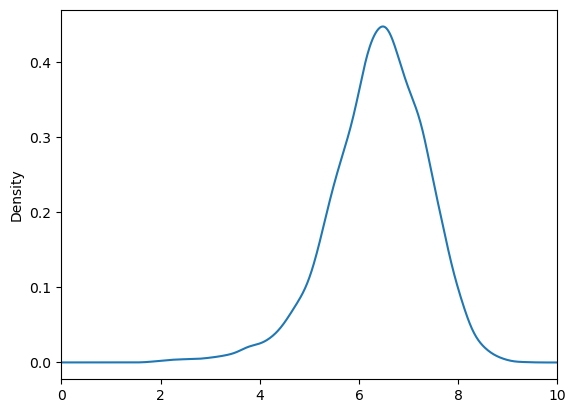

In [9]:
labels.plot.density(xlim=[0, 10])

Since our labels follow a normal distribution, our dataset has a class imbalance where the majority of our records have scores between 5 and 8. This is important to note for our models later on.

Next, we explore the votes attribute of our dataset, since the distribution looked suspicious within Kaggle's visualization. We do so by creating a histogram of the data's distribution by votes and generating summary statistics.

<AxesSubplot: title={'center': 'Distribution of dataset by votes'}, ylabel='Frequency'>

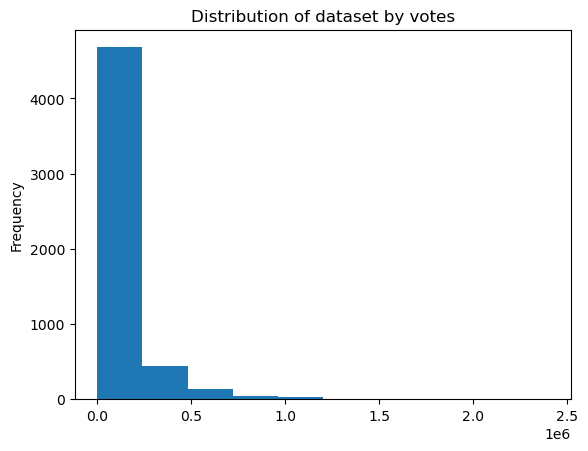

In [10]:
data['votes'].plot(kind='hist', title='Distribution of dataset by votes')

In [11]:
data['votes'].describe().apply("{0:.2f}".format)

count       5359.00
mean      115823.93
std       185011.57
min          195.00
25%        19000.00
50%        53000.00
75%       131000.00
max      2400000.00
Name: votes, dtype: object

We found that the distribution of votes was highly right skewed. However, this is not necessarily anomalous given that movies with higher scores tend to receive more votes due to more exposure/popularity. Therefore, we kept the votes feature as is since it could indicate a pattern for score predictions.

We also noticed that there were a few unusual values for the rating attribute, namely 
"TV-MA", "NC-17", and "X". These categorical outliers will be addressed in our feature engineering section.

In [12]:
data['rating'].value_counts() 

R        2597
PG-13    1729
PG        907
G         111
NC-17      12
TV-MA       2
X           1
Name: rating, dtype: int64

We then examined the data for any correlations between continuous values. This will be useful when determining which features to use for our modeling algorithms and whether we can perform dimension reduction on any columns.

In [13]:
features = data.copy()
features = features.drop(columns=['score'])
features.corr()

/var/folders/ps/frvdw_b12331xc41xqrqbff80000gn/T/ipykernel_42314/4050368262.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  features.corr()


,year,votes,budget,gross,runtime
year,1.000000,0.207662,0.330342,0.275968,0.073406
votes,0.207662,1.000000,0.439428,0.615622,0.358178
budget,0.330342,0.439428,1.000000,0.739373,0.323501
gross,0.275968,0.615622,0.739373,1.000000,0.279794
runtime,0.073406,0.358178,0.323501,0.279794,1.000000


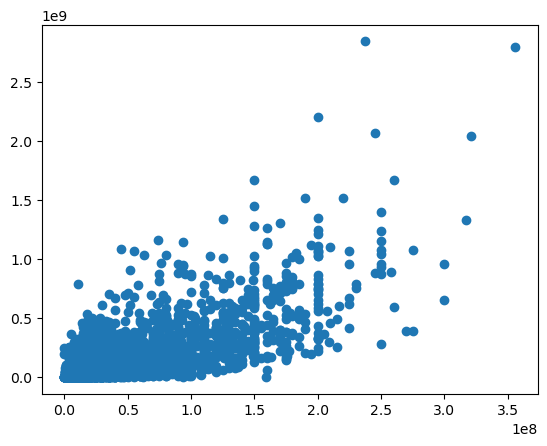

In [14]:
# Plot correlation between budget and gross
plt.scatter(x=data['budget'], y=data['gross'])
plt.show()

We found a strong positive correlation of 0.74 between budget and gross, which we then examined in a scatterplot. During feature engineering, we will combine these two features into one in order to reduce the number of dimensions and prevent overfitting on these values. 

## Feature Engineering 

First, we wanted to resolve the rating outliers we discovered while exploring our data. After further research, we found that all our outlier values shared similar definitions to the more frequent "R" rating. Since they all referred to mature audiences, we decided to group them all as "R" to create a clearer pattern in the data for our modeling algorithms to use.

In [15]:
data = data.replace("TV-MA", "R")
data = data.replace("NC-17", "R")
data = data.replace("X", "R")

We also decided to create a new feature, profits, and drop the gross and budget features in order to reduce the dimensions by 1 and prevent overfitting on monetary data.

In [16]:
data['profits'] = data['gross'] - data['budget']
data = data.drop(columns=['gross','budget'])
data.head()

,rating,genre,year,released,score,votes,director,writer,star,country,company,runtime,profits
0,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,Warner Bros.,146.0,27998772.0
1,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,Columbia Pictures,104.0,54353106.0
2,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,Lucasfilm,124.0,520375067.0
3,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,Paramount Pictures,88.0,79953539.0
4,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,Orion Pictures,98.0,33846344.0


We then performed feature transformation using the released attribute. We created features for release month, storing it as a pair of sine and cosine features in order to represent the cyclical nature of months.

In [17]:
def encode_time(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

# remove all records that are not in the "month day, year (country)" format for the released column
data['length'] = data['released'].str.count(" ")
data = data[data['length'] >= 3]

# extract month from released, then drop released
data[['month', 'rest']] = data['released'].str.split(' ', n=1, expand=True)
data = data.drop(columns=['released', 'rest'])

# map string month to numerical value
month_dict = {'January':1,
             'February':2,
             'March':3,
             'April':4,
             'May':5,
             'June':6,
             'July':7,
             'August':8,
             'September':9,
             'October':10,
             'November':11,
             'December':12}

data['month'] = data['month'].map(month_dict)

# create cyclical features for month
encode_time(data, 'month', 12)
labels = data['score']
data = data.drop(columns=['month', 'length', 'score'])
data.head()

,rating,genre,year,votes,director,writer,star,country,company,runtime,profits,month_sin,month_cos
0,R,Drama,1980,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,Warner Bros.,146.0,27998772.0,1.224647e-16,-1.000000
1,R,Adventure,1980,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,Columbia Pictures,104.0,54353106.0,-5.000000e-01,-0.866025
2,PG,Action,1980,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,Lucasfilm,124.0,520375067.0,1.224647e-16,-1.000000
3,PG,Comedy,1980,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,Paramount Pictures,88.0,79953539.0,-5.000000e-01,-0.866025
4,R,Comedy,1980,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,Orion Pictures,98.0,33846344.0,-5.000000e-01,-0.866025


Next, we converted our categorical features into numerical ones.
<br><br>
For the rating feature, we ordinally mapped ratings to values 1, 2, 3, and 4, since there is a natural order to this attribute.

In [18]:
# reset index
data = data.reset_index()
data = data.drop(columns=['index'])

In [19]:
rating_dict = {
    'G': 1,
    'PG': 2,
    'PG-13': 3,
    'R': 4
}
data_encoded = data.copy()
data_encoded['rating_num'] = data_encoded['rating'].map(rating_dict)
data_encoded = data_encoded.drop(columns=['rating'])
data_encoded.head()

,genre,year,votes,director,writer,star,country,company,runtime,profits,month_sin,month_cos,rating_num
0,Drama,1980,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,Warner Bros.,146.0,27998772.0,1.224647e-16,-1.000000,4
1,Adventure,1980,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,Columbia Pictures,104.0,54353106.0,-5.000000e-01,-0.866025,4
2,Action,1980,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,Lucasfilm,124.0,520375067.0,1.224647e-16,-1.000000,2
3,Comedy,1980,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,Paramount Pictures,88.0,79953539.0,-5.000000e-01,-0.866025,2
4,Comedy,1980,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,Orion Pictures,98.0,33846344.0,-5.000000e-01,-0.866025,4


Next, we used one hot encoding to number our genre column. We chose to do this because there are only 15 genres, and thus only 14 additonal features will be created (once we drop 'genre').

In [20]:
print("Number of unique genres:", len(pd.unique(data['genre'])))

Number of unique genres: 15


The following pie chart displays the distribution of genres:

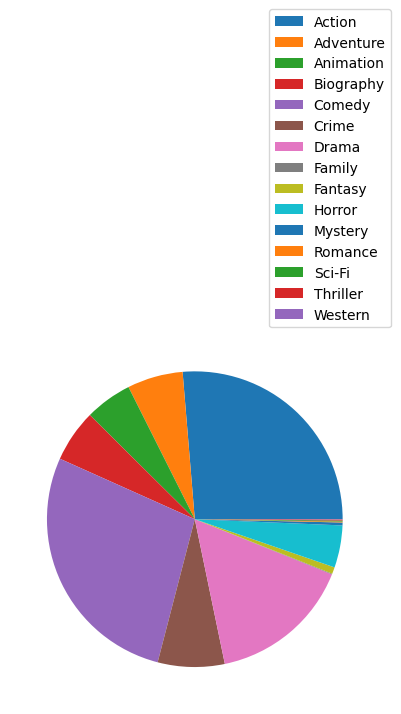

In [21]:
genre = data.groupby('genre')
sizes = genre.size()

plt.pie(sizes, labels=['Action', 'Adventure', 'Animation', 'Biography','Comedy','Crime','Drama','Family','Fantasy',
                       'Horror','Mystery','Romance','Sci-Fi','Thriller','Western'], labeldistance=None)
plt.legend(bbox_to_anchor=(1.05, 1),loc='lower right')
plt.show()

In [22]:
data_encoded = pd.get_dummies(data_encoded, columns=['genre'], drop_first=False)
data_encoded.head()

,year,votes,director,writer,star,country,company,runtime,profits,month_sin,...,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_Western
0,1980,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,Warner Bros.,146.0,27998772.0,1.224647e-16,...,0,1,0,0,0,0,0,0,0,0
1,1980,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,Columbia Pictures,104.0,54353106.0,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
2,1980,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,Lucasfilm,124.0,520375067.0,1.224647e-16,...,0,0,0,0,0,0,0,0,0,0
3,1980,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,Paramount Pictures,88.0,79953539.0,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
4,1980,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,Orion Pictures,98.0,33846344.0,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0


We then performed feature transformations on director, writer, star, country, and company by turning them from strings (representing names, film companies, etc.) to numerical frequency counts (representing how many times the value occurred in the column). We chose to do this because these columns have many unique values and should not be one hot encoded, since it would result in thousands of new columns being added. Instead, we used CountEncoder from the category_encoders library to store frequency counts.

In [23]:
!pip install category_encoders
from category_encoders import CountEncoder

data_encoded = CountEncoder(cols=['director', 'writer', 'star', 'country', 'company']).fit(data_encoded).transform(data_encoded)
data_encoded.head()

,year,votes,director,writer,star,country,company,runtime,profits,month_sin,...,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_Western
0,1980,927000.0,2,29,18,485,298,146.0,27998772.0,1.224647e-16,...,0,1,0,0,0,0,0,0,0,0
1,1980,65000.0,4,2,4,4290,302,104.0,54353106.0,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
2,1980,1200000.0,3,1,2,4290,10,124.0,520375067.0,1.224647e-16,...,0,0,0,0,0,0,0,0,0,0
3,1980,221000.0,6,6,3,4290,279,88.0,79953539.0,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
4,1980,108000.0,9,2,16,4290,46,98.0,33846344.0,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# reset index
data = data.reset_index()
data = data.drop(columns=['index'])

## Modeling

We will now create models to predict IMDb scores using 5 different methods: linear regression, decision trees, neural networks, KNN regression, and SVR.

### Linear Regression

To start off, we decided to try multiple linear regression since we are predicting a continuous target and noticed correlations between features while exploring the data. Since we have many features, running linear regression will find the best fit hyperplane for our data.

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

# function to calculate adjusted R2
def get_adj_r2(r2, n, p):
    return (1-(1-r2)*((n-1)/(n-p-1)))

model = LinearRegression()
labels_reg = labels.values.reshape(-1,1)
scores = cross_validate(model, data_encoded, labels_reg, cv=5, scoring= ["r2", "neg_mean_absolute_error", 
                                                                         "neg_root_mean_squared_error"])
r2_reg = scores["test_r2"].mean()
adj_r2_reg = get_adj_r2(r2_reg, data_encoded.shape[0], data_encoded.shape[1])
mae_reg = abs(scores["test_neg_mean_absolute_error"].mean())
rmse_reg = abs(scores["test_neg_root_mean_squared_error"].mean())
print("R2:", r2_reg)
print("Adjusted R2:", adj_r2_reg)
print("MAE:", mae_reg)
print("RMSE:", rmse_reg)


R2: 0.36094994568121097
Adjusted R2: 0.35771030026878003
MAE: 0.5794501093365377
RMSE: 0.7652884584125175


The relatively low R2 score indicates that when taking our features into account to predict scores, only 36% of the variance is explained/reduced. Typically, an R2 of less than 0.25 indicates that little to no variation is explained by the independent variables. Therefore, we did have some success with linear regression, but it may not be the most suitable approach for this task.

### Decision Trees

Next, we decided to change our approach and view our task as a classification problem in order to find out if this improved our predicition accuracy.
<br><br>
Since we are using a decision tree, we must bin our continous target value (scores, stored as floats) into categorical target values (scores, stored as ints ranging from 0 to 10).

In [26]:
labels_tree = labels.round(0).astype(int)

Since we discovered that our dataset had a class imbalance, we first used SMOTE to mitigate the imbalance. We then created a decision tree and found our optimal hyperparameters.

In [27]:
!pip install imblearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

smote = SMOTE()
clf = DecisionTreeClassifier()
pipeline = imbpipeline(steps=[('smote', smote),  ('clf', clf)])

params = {"clf__max_depth": [5,10,15,20,25,30], 
          "clf__min_samples_leaf": [15,20,25,30,35,40],
          "clf__max_features": [14,20,26]}

grid_search = GridSearchCV(pipeline, params, cv=5, scoring='accuracy')
grid_search.fit(data_encoded, labels_tree)

print("Accuracy:", grid_search.best_score_*100)
print(grid_search.best_params_)
tree_params = grid_search.best_params_

Accuracy: 38.42044730664852
{'clf__max_depth': 25, 'clf__max_features': 20, 'clf__min_samples_leaf': 15}


To get a more accurate accuracy metric, we also ran the model using cross_val_score() with 5 trials.

In [38]:
smote = SMOTE()
clf = DecisionTreeClassifier(max_depth=tree_params['clf__max_depth'], max_features=tree_params['clf__max_features'], 
                             min_samples_leaf=tree_params['clf__min_samples_leaf'])

pipeline = imbpipeline(steps=[('smote', smote),  ('clf', clf)])

grid_search = GridSearchCV(pipeline, params, cv=5, scoring='accuracy')
nested_score = cross_val_score(grid_search, data_encoded, labels_tree, cv=5)
print("Accuracy:", nested_score.mean())

Accuracy: 0.3651540616246499


Our model correctly predicts the score about 37% of the time. This may indicate that our dataset is difficult to use to predict scores, but we will continue trying other models to see if our accuracy can be improved.

Since our accuracy was low, we decided to evaluate how far off our decision tree predictions were compared to the (rounded) true labels. This revealed that the decision tree performed decently well since y_pred was only 0.9 off from the y_test label on average.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_encoded, labels_tree, test_size=0.20)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

clf = DecisionTreeClassifier(max_depth=tree_params['clf__max_depth'], max_features=tree_params['clf__max_features'], 
                             min_samples_leaf=tree_params['clf__min_samples_leaf'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [30]:
# Calculate how far off our predicitions were

total_diff = 0
for i in range(len(y_pred)):
    total_diff += abs(y_pred[i] - y_test.iloc[i])
avg_diff = total_diff / len(y_pred)
print("Distance from correct category:", avg_diff)

Distance from correct category: 0.9169000933706816


We then created a confusion matrix and classification report to further analyze the results of our decision tree.

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  0   1   0   0   4   1   0   0]
 [  1   1   0   0   0   0   0   0]
 [  2   3   7   3  10   2   1   0]
 [  5  11  20  28  36  24   2   0]
 [  9  24  28  99 173  75  16   0]
 [  4   8  19  34  88 150  60   0]
 [  0   1   2   3  11  32  69   1]
 [  0   0   0   0   0   0   0   3]]
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         6
           3       0.02      0.50      0.04         2
           4       0.09      0.25      0.13        28
           5       0.17      0.22      0.19       126
           6       0.54      0.41      0.46       424
           7       0.53      0.41      0.46       363
           8       0.47      0.58      0.52       119
           9       0.75      1.00      0.86         3

    accuracy                           0.40      1071
   macro avg       0.32      0.42      0.33      1071
weighted avg       0.47      0.40      0.43      1071



Note: After our data prep and feature engineering, the range of our scores decreased, which is why there are only 8 categories for our decision tree after rounding the labels, as shown below.

In [32]:
print("Min score:", labels.min())
print("Max score:", labels.max())
print(pd.unique(labels_tree))

Min score: 1.9
Max score: 9.3
[8 6 9 7 5 4 3 2]


Because we used SMOTE, we know from our confusion matrix and classification report that the data is now less unbalanced (since running the same code with the original unbalanced dataset resulted in many more 0s).
<br><br>
The decision tree's precision reveals that the model has the highest proportion of correct predictions among all predictions of a certain class for classes 6, 7, and 8. This makes sense since in our data exploration section, we found that most records had scores in the range of 6 to 8.
<br><br>
The recall reveals that the proportion of records of a certain class that were correctly predicted was highest for classes 8 and 9.
<br><br>
The F1-score takes into account precision and recall, and is thus the overall measure of the decision tree's prediction quality. Overall, our tree was best at predicting records with scores of 6 to 9. Likely, this is due to a combination of factors: there are more records for scores 6-8, and records with scores 6-9 may have more patterns in their features that are useful for predictions.

Since this was not very successful, for our remaining models we will attempt to use continuous target values to see if we can improve our accuracy. However, this means we can no longer use SMOTE to create a more well-balanced dataset. While we considered alternatives such as SMOGN, there is little research/information on how to use these tools and how to apply them within a pipeline. Therefore, we decided to use our dataset as is for the purposes of this project.

### Neural Nets
<br>
Since neural networks can learn complex decision boundaries and handle irrelevant or redundant attributes, we decided to try this next. We will use the scikit-learn MLPRegressor to output continuous values for IMDb scores.

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()
mlp = MLPRegressor()
pipeline = Pipeline(steps=[('scaler', scaler),  ('mlp', mlp)])

param_grid = {
    'mlp__hidden_layer_sizes': list(range(30, 70, 10)),
    'mlp__activation': ['logistic', 'tanh', 'relu', 'identity']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# ** for testing purposes to determine best hyperparameters **
# grid_search.fit(data_encoded, labels)
# print(grid_search.best_params_)
# print(grid_search.best_score_)

scores = cross_validate(grid_search, data_encoded, labels, cv=5, scoring= ["r2", "neg_mean_absolute_error", 
                                                                           "neg_root_mean_squared_error"])
r2_nn = scores["test_r2"].mean()
mae_nn = abs(scores["test_neg_mean_absolute_error"].mean())
rmse_nn = abs(scores["test_neg_root_mean_squared_error"].mean())
print("R2:", r2_nn)
print("MAE:", mae_nn)
print("RMSE:", rmse_nn)


/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

R2: 0.4019466833106738
MAE: 0.5496463991076361
RMSE: 0.7365214185086321


/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Using the MLPRegressor showed improvements over our initial linear regression model, since MLPRegressor's R2 was higer and its MAE and RMSE were lower. A more in-depth comparison will be conducted after all our models have been run.

### K-Nearest Neighbors

Next, we used scikit-learn's KNeighborsRegressor, which is the regression equivalent of the KNN algorithm. After scaling and reducing the dimensions of our data, we tested this algorithm with 5 to 50 neighbors in order to determine the best value of k (which ended up being 26).

In [34]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

pca = PCA()
neigh = KNeighborsRegressor()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', neigh)])


param_grid = {
    'pca__n_components': list(range(5, 26)),
    'knn__n_neighbors': list(range(5, 50))
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# ** for testing purposes to determine best hyperparameters **
# grid_search.fit(data_encoded, labels)
# print(grid_search.best_params_)
# print(grid_search.best_score_)

scores = cross_validate(grid_search, data_encoded, labels, cv=5, scoring= ["r2", "neg_mean_absolute_error", 
                                                                           "neg_root_mean_squared_error"])
r2_knn = scores["test_r2"].mean()
mae_knn = abs(scores["test_neg_mean_absolute_error"].mean())
rmse_knn = abs(scores["test_neg_root_mean_squared_error"].mean())
print("R2:", r2_knn)
print("MAE:", mae_knn)
print("RMSE:", rmse_knn)


R2: 0.30191991888360625
MAE: 0.6158772253877423
RMSE: 0.7989122661166784


### SVR

Lastly, we tried SVR, which is similar to SVM but works with continuous values instead of classification. We performed hyperparameter tuning on the kernel function in order to determine the best kernel for our dataset. We also tested different values of epsilon, which controlled the width of the tube around the hyperplane (note: we also performed hyperparameter tuning on C, the regularization parameter used for slack, but we've removed it now since it resulted in the default C=1 and significantly increased our runtime).

In [35]:
from sklearn.svm import SVR

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
svr = SVR()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svr', svr)])

param_grid = {
    'pca__n_components': list(range(5, 26)),
    'svr__kernel': ['linear', 'rbf', 'poly'],
    'svr__epsilon': [0.1, 0.25, 0.5, 0.75], # note: we start at the default tube width of 0.1
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# ** for testing purposes to determine best hyperparameters **
# grid_search.fit(data_svr, labels)
# print(grid_search.best_params_)
# print(grid_search.best_score_)

scores = cross_validate(grid_search, data_encoded, labels, cv=5, scoring= ["r2", "neg_mean_absolute_error", 
                                                                           "neg_root_mean_squared_error"])
r2_svr = scores["test_r2"].mean()
mae_svr = abs(scores["test_neg_mean_absolute_error"].mean())
rmse_svr = abs(scores["test_neg_root_mean_squared_error"].mean())
print("R2:", r2_svr)
print("MAE:", mae_svr)
print("RMSE:", rmse_svr)


R2: 0.4167730767685212
MAE: 0.5455867069655065
RMSE: 0.7304156211204056


We found that the best value of epsilon was 0.5, which indicates that our model worked best when we allowed for a greater magrin of tolerance than the default 0.1 epsilon tube.

## Outcome/Results & Comparisons

### Predicting a categorical score:

**Decision Tree**
<br>
Accuracy: 36.51540616246499<br>
Avg distance from correct category: 0.9169000933706816
<br>

Because we have only one model based on accuracy, it is difficult to compare if it did better or worse than other models. However, we know from previous assignments that a model with 37% accuracy is performing poorly. Moreover, the decision tree will output a less precise prediction than our other models. Therefore, this is not the best approach.
<br>

### Predicting a continous score:

**Multiple Linear Regression**
<br>
R2: 0.36094994568121097<br>
MAE: 0.5794501093365377<br>
RMSE: 0.7652884584125175

**MLPRegressor Neural Network**
<br>
R2: 0.4019466833106738<br>
MAE: 0.5496463991076361<br>
RMSE: 0.7365214185086321

**KNeighborsRegressor**
<br>
R2: 0.30191991888360625<br>
MAE: 0.6158772253877423<br>
RMSE: 0.7989122661166784

**Support Vector Regression**
<br>
R2: 0.4167730767685212<br>
MAE: 0.5455867069655065<br>
RMSE: 0.7304156211204056

<br>
Overall, the SVR model had the highest R2 and lowest MAE and RMSE, and is thus the best model to use for predicting scores based off Movie Industry data. The higher R2 indicates that we got the best fit between our observations and predictions by using SVR (aka 42% of the variation in our features could be explained by score in the SVR model). We also used MAE and RMSE to measure accuracy for continuous variables. The MAE indicates that, on average, we had an absolute difference of 0.55 between our actual and predicted scores when using SVR. The RMSE indicates that the square root of the average of squared differences between our actual and predicted scores was 0.73 with SVR. Given that our target variable ranged from 0 to 10 and had one decimal place, these metrics show that SVR predicted scores fairly well. 
<br>
After SVR, MLPRegressor did second best (it was only slightly worse than SVR), followed by linear regression and then KNeighborsRegressor.
<br><br> 
One caveat is that our data was not very well balanced (since most of our data tended to have scores between 5 and 8), and thus our prediction accuracy will likely be lower for a balanced dataset. However, our decision tree did use SMOTE to balance the dataset more, and still performed decently with an average difference of 0.92 between actual and predicted scores.
<br><br>
One way we could improve our models' abilities to make accurate predictions would be to increase the number of records in the dataset in order to make trends in the data more apparent. Having a more well balanced initial dataset would also help. Additionally, we could merge the current dataset with other datasets that contain additional attributes about our movies in order to add more relevant features to our dataset.
<br><br>
We also included a visual comparison of our models' metrics below:

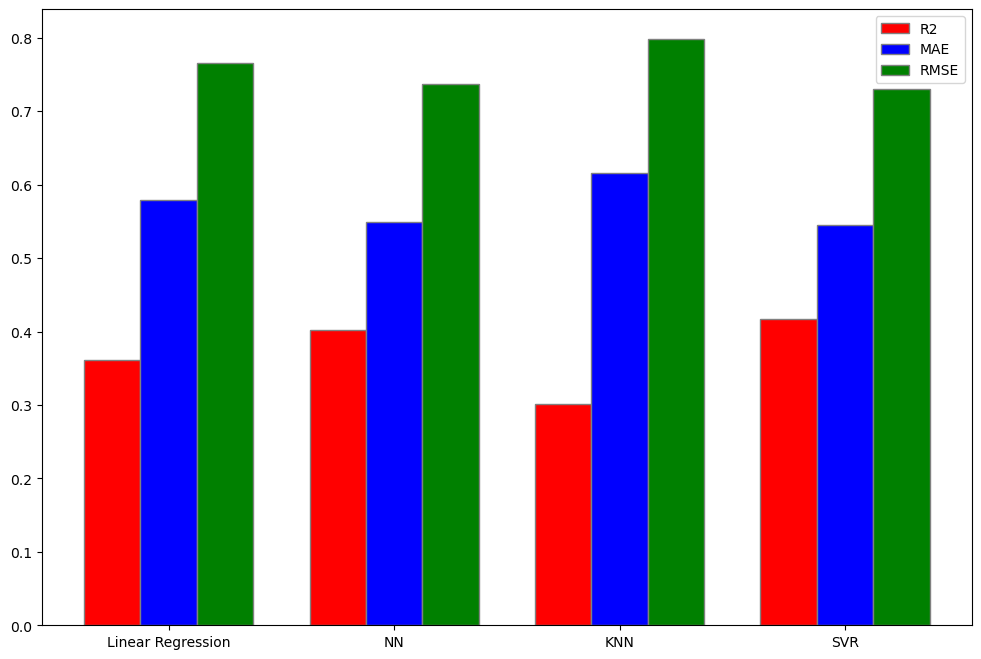

In [37]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
R2 = [r2_reg, r2_nn, r2_knn, r2_svr]
MAE = [mae_reg, mae_nn, mae_knn, mae_svr]
RMSE = [rmse_reg, rmse_nn, rmse_knn, rmse_svr]

# Set position of bar on X axis
br1 = np.arange(len(R2))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, R2, color ='r', width = barWidth,
        edgecolor ='grey', label ='R2')
plt.bar(br2, MAE, color ='b', width = barWidth,
        edgecolor ='grey', label ='MAE')
plt.bar(br3, RMSE, color ='g', width = barWidth,
        edgecolor ='grey', label ='RMSE')


# Adding Xticks
plt.xticks([r + barWidth for r in range(len(R2))],
        ['Linear Regression', 'NN', 'KNN', 'SVR'])

plt.legend()
plt.show()